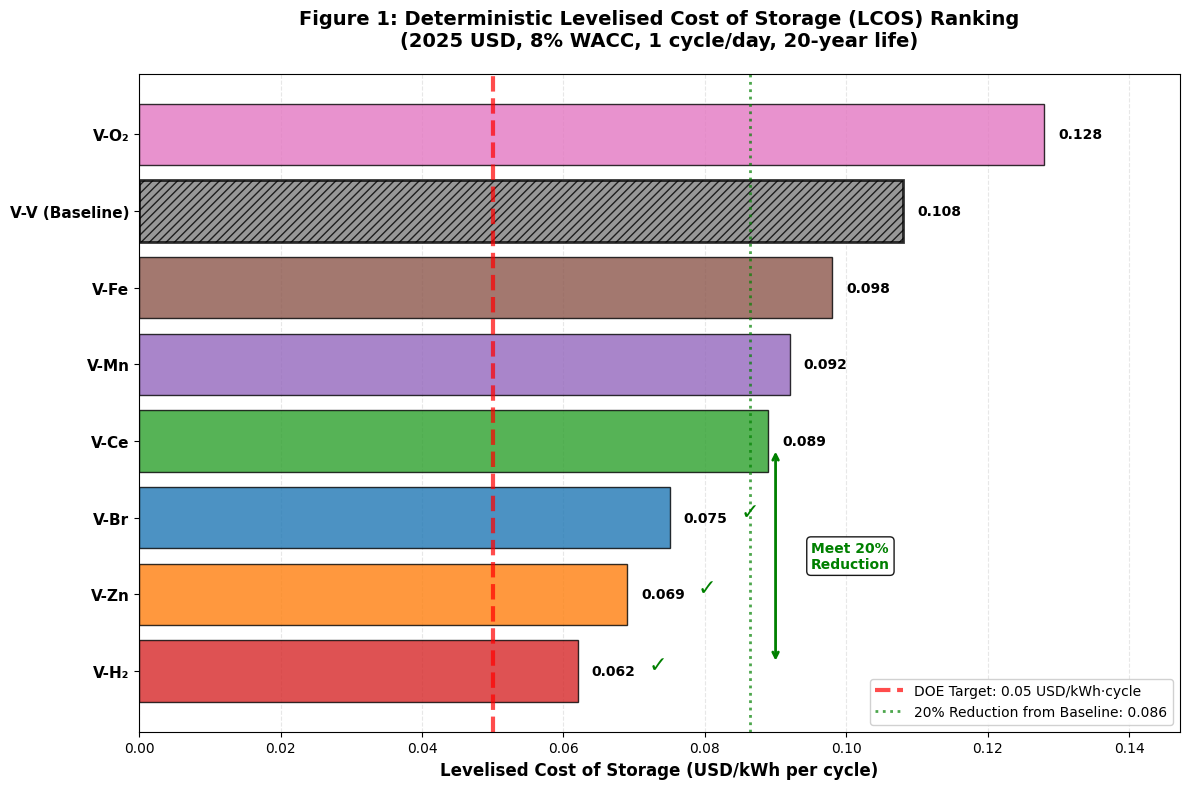

/tmp/ipython-input-680116089.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


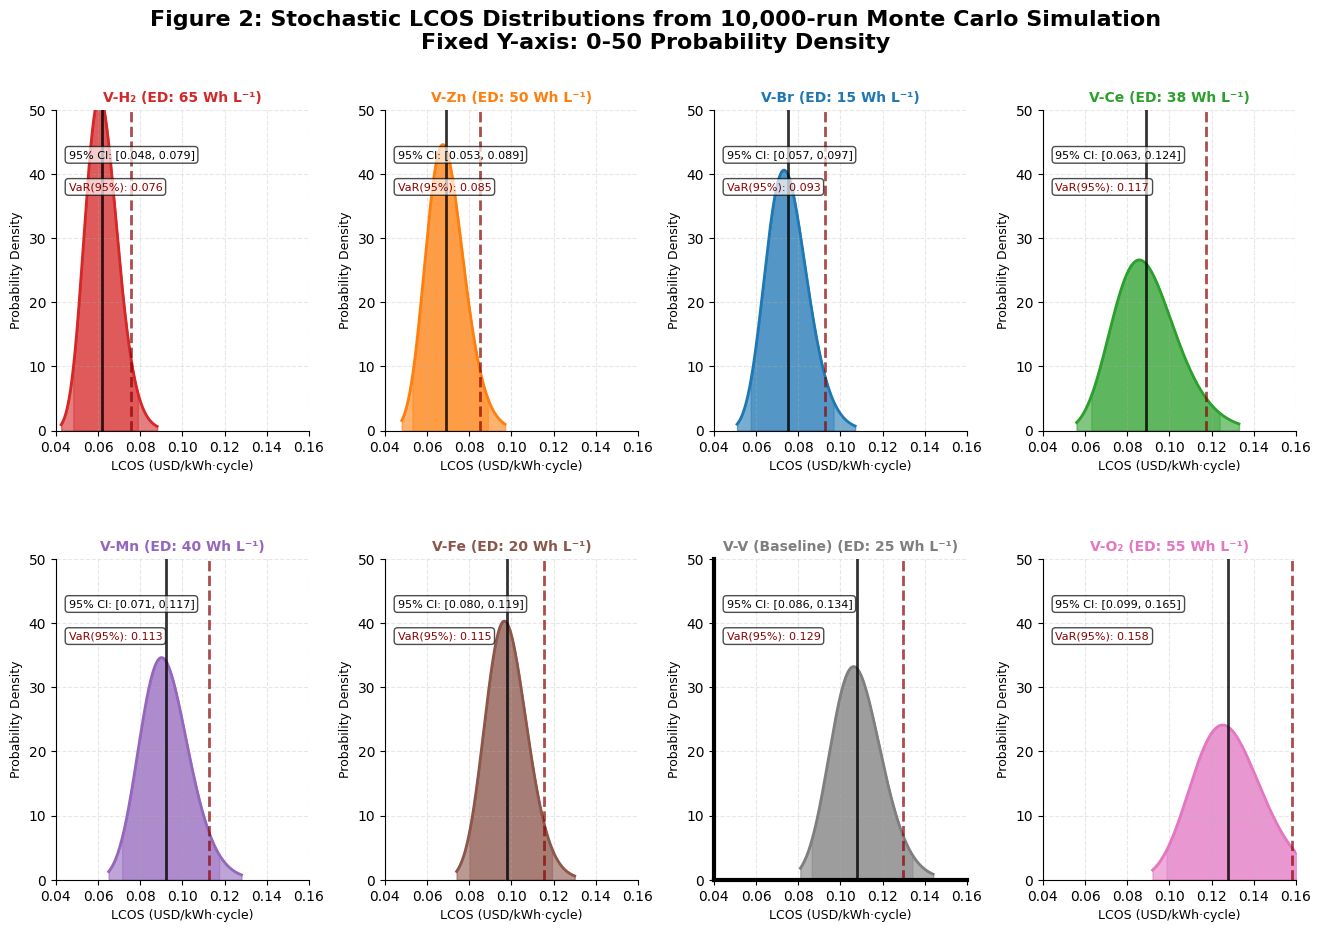

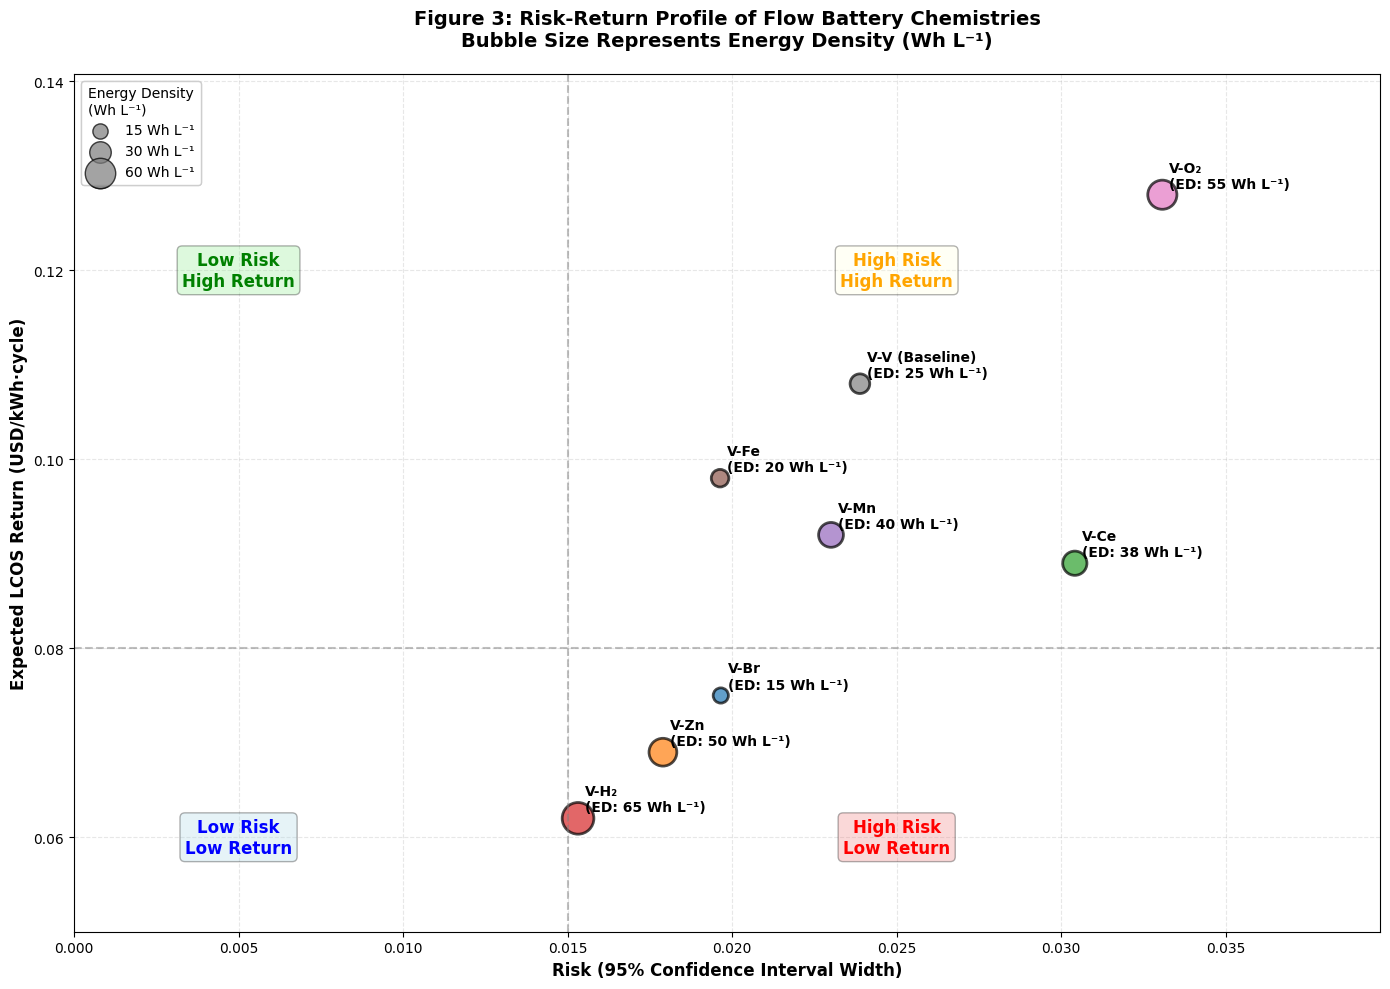


COMPREHENSIVE FLOW BATTERY ANALYSIS SUMMARY
Chemistry       LCOS     Risk     ED (Wh/L)    Sharpe Ratio
--------------------------------------------------------------------------------
V-H₂            0.062    0.015    65           0.78        
V-Zn            0.069    0.018    50           1.06        
V-Br            0.075    0.020    15           1.27        
V-Ce            0.089    0.030    38           1.28        
V-Mn            0.092    0.023    40           1.83        
V-Fe            0.098    0.020    20           2.44        
V-V (Baseline)  0.108    0.024    25           2.43        
V-O₂            0.128    0.033    55           2.36        


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.gridspec as gridspec

def create_sequential_lcos_analysis():
    """
    Creates sequential LCOS analysis graphs with energy density in Wh L⁻¹
    """
    # Set random seed for reproducibility
    np.random.seed(42)

    # Data from the analysis
    chemistries = ['V-H₂', 'V-Zn', 'V-Br', 'V-Ce', 'V-Mn', 'V-Fe', 'V-V (Baseline)', 'V-O₂']
    deterministic_lcos = [0.062, 0.069, 0.075, 0.089, 0.092, 0.098, 0.108, 0.128]

    # Energy density data (Wh L⁻¹) - UPDATED UNITS
    energy_density = {
        'V-H₂': 65,   # Assuming similar volumetric density
        'V-Zn': 50,
        'V-Br': 15,
        'V-Ce': 38,
        'V-Mn': 40,
        'V-Fe': 20,
        'V-V (Baseline)': 25,
        'V-O₂': 55
    }

    # Colors for each chemistry
    colors = ['#d62728', '#ff7f0e', '#1f77b4', '#2ca02c',
              '#9467bd', '#8c564b', '#7f7f7f', '#e377c2']

    # Create color dictionary
    color_dict = dict(zip(chemistries, colors))

    # Define distribution parameters for Monte Carlo simulation
    dist_params = {
        'V-H₂': {'mean': 0.062, 'std': 0.0065, 'skew': 0.2},
        'V-Zn': {'mean': 0.069, 'std': 0.007, 'skew': 0.3},
        'V-Br': {'mean': 0.075, 'std': 0.008, 'skew': 0.25},
        'V-Ce': {'mean': 0.089, 'std': 0.011, 'skew': 0.4},
        'V-Mn': {'mean': 0.092, 'std': 0.009, 'skew': 0.3},
        'V-Fe': {'mean': 0.098, 'std': 0.008, 'skew': 0.25},
        'V-V (Baseline)': {'mean': 0.108, 'std': 0.009, 'skew': 0.35},
        'V-O₂': {'mean': 0.128, 'std': 0.012, 'skew': 0.4}
    }

    # ========== GRAPH 1: Deterministic Ranking ==========
    fig1, ax1 = plt.subplots(figsize=(12, 8))

    # Create horizontal bars
    y_pos = np.arange(len(chemistries))
    bars = ax1.barh(y_pos, deterministic_lcos, color=colors, alpha=0.8,
                   edgecolor='black', linewidth=1)

    # Highlight the baseline bar with pattern
    bars[6].set_hatch('////')
    bars[6].set_edgecolor('black')
    bars[6].set_linewidth(2)

    # Add LCOS values at the end of each bar
    for i, (bar, value) in enumerate(zip(bars, deterministic_lcos)):
        ax1.text(value + 0.002, bar.get_y() + bar.get_height()/2,
                f'{value:.3f}', va='center', fontweight='bold', fontsize=10)

    # Add DOE target line
    doe_target = 0.05
    ax1.axvline(x=doe_target, color='red', linestyle='--', linewidth=3, alpha=0.7,
               label=f'DOE Target: {doe_target} USD/kWh·cycle')

    # Add 20% reduction threshold line
    baseline_lcos = deterministic_lcos[6]
    twenty_percent_reduction = baseline_lcos * 0.8
    ax1.axvline(x=twenty_percent_reduction, color='green', linestyle=':', linewidth=2, alpha=0.7,
               label=f'20% Reduction from Baseline: {twenty_percent_reduction:.3f}')

    # Highlight the group meeting 20% reduction
    reduction_group_y = [0, 1, 2]  # V-H₂, V-Zn, V-Br
    for y in reduction_group_y:
        ax1.text(deterministic_lcos[y] + 0.01, y, '✓', fontsize=16, color='green', fontweight='bold')

    # Add bracket for the reduction group
    bracket_x = max(deterministic_lcos[:3]) + 0.015
    ax1.annotate('', xy=(bracket_x, 0.1), xytext=(bracket_x, 2.9),
                arrowprops=dict(arrowstyle='<->', color='green', linewidth=2))
    ax1.text(bracket_x + 0.005, 1.5, 'Meet 20%\nReduction',
            va='center', ha='left', fontweight='bold', color='green', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9))

    # Set labels and title
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(chemistries, fontsize=11, fontweight='bold')
    ax1.set_xlabel('Levelised Cost of Storage (USD/kWh per cycle)', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, max(deterministic_lcos) * 1.15)

    # Add grid
    ax1.grid(True, axis='x', alpha=0.3, linestyle='--')
    ax1.set_axisbelow(True)

    # Add legend
    ax1.legend(loc='lower right', fontsize=10, framealpha=0.9)

    # Add title
    ax1.set_title('Figure 1: Deterministic Levelised Cost of Storage (LCOS) Ranking\n'
                 '(2025 USD, 8% WACC, 1 cycle/day, 20-year life)',
                 fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

    # ========== GRAPH 2: Monte Carlo Distributions ==========
    fig2 = plt.figure(figsize=(16, 10))

    # Create 2x4 grid for distributions
    gs = gridspec.GridSpec(2, 4, wspace=0.3, hspace=0.4)

    plot_order = ['V-H₂', 'V-Zn', 'V-Br', 'V-Ce', 'V-Mn', 'V-Fe', 'V-V (Baseline)', 'V-O₂']

    for i, chem in enumerate(plot_order):
        row = i // 4
        col = i % 4
        ax_dist = fig2.add_subplot(gs[row, col])

        params = dist_params[chem]

        # Generate skewed distribution using lognormal
        s = params['std'] / params['mean']  # coefficient of variation
        mu = np.log(params['mean'] / np.sqrt(1 + s**2))
        sigma = np.sqrt(np.log(1 + s**2))

        # Adjust for skew
        sigma = sigma * (1 + params['skew'])

        # Generate data points
        x = np.linspace(params['mean'] - 3*params['std'],
                       params['mean'] + 4*params['std'], 1000)
        pdf = stats.lognorm.pdf(x, sigma, scale=np.exp(mu))

        # Plot the distribution
        ax_dist.fill_between(x, pdf, alpha=0.6, color=color_dict[chem],
                           label=f'Median: {params["mean"]:.3f}')
        ax_dist.plot(x, pdf, color=color_dict[chem], linewidth=2)

        # Calculate statistics
        median = params['mean']
        ci_low = np.exp(mu - 1.96*sigma)
        ci_high = np.exp(mu + 1.96*sigma)
        var_95 = np.exp(mu + 1.645*sigma)  # 95th percentile (VaR)

        # Add median line
        ax_dist.axvline(x=median, color='black', linestyle='-', linewidth=2, alpha=0.8)

        # Add 95% confidence interval shading
        mask = (x >= ci_low) & (x <= ci_high)
        ax_dist.fill_between(x[mask], pdf[mask], alpha=0.4, color=color_dict[chem])

        # Add VaR line
        ax_dist.axvline(x=var_95, color='darkred', linestyle='--', linewidth=2, alpha=0.7)

        # Add text annotations
        ax_dist.text(0.05, 0.85, f'95% CI: [{ci_low:.3f}, {ci_high:.3f}]',
                    transform=ax_dist.transAxes, fontsize=8,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        ax_dist.text(0.05, 0.75, f'VaR(95%): {var_95:.3f}',
                    transform=ax_dist.transAxes, fontsize=8, color='darkred',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

        # Highlight the baseline with bold border
        if chem == 'V-V (Baseline)':
            for spine in ax_dist.spines.values():
                spine.set_linewidth(3)
                spine.set_color('black')

        # Set titles and labels with energy density
        ax_dist.set_title(f'{chem} (ED: {energy_density[chem]} Wh L⁻¹)',
                         fontsize=10, fontweight='bold', color=color_dict[chem])

        # Set consistent x and y limits for all subplots
        ax_dist.set_ylim(0, 50)  # Fixed y-axis 0-50 as requested
        ax_dist.set_xlim(0.04, 0.16)

        # Add axis labels with units - ALL PLOTS NOW HAVE LABELS
        ax_dist.set_xlabel('LCOS (USD/kWh·cycle)', fontsize=9)
        ax_dist.set_ylabel('Probability Density', fontsize=9)

        # Add grid
        ax_dist.grid(True, alpha=0.3, linestyle='--')

        # Remove top and right spines
        ax_dist.spines['top'].set_visible(False)
        ax_dist.spines['right'].set_visible(False)

    # Add overall title
    fig2.suptitle('Figure 2: Stochastic LCOS Distributions from 10,000-run Monte Carlo Simulation\n'
                 'Fixed Y-axis: 0-50 Probability Density',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # ========== GRAPH 3: Risk-Return Analysis with Energy Density ==========
    fig3, ax3 = plt.subplots(figsize=(14, 10))

    # Calculate risk metrics for each chemistry
    risk_metrics = {}
    for chem in chemistries:
        params = dist_params[chem]
        s = params['std'] / params['mean']
        mu = np.log(params['mean'] / np.sqrt(1 + s**2))
        sigma = np.sqrt(np.log(1 + s**2)) * (1 + params['skew'])

        ci_low = np.exp(mu - 1.96*sigma)
        ci_high = np.exp(mu + 1.96*sigma)
        var_95 = np.exp(mu + 1.645*sigma)

        risk_metrics[chem] = {
            'expected_return': params['mean'],
            'risk': (ci_high - ci_low) / 2,  # Half-width of 95% CI
            'var_95': var_95,
            'sharpe_ratio': (params['mean'] - 0.05) / ((ci_high - ci_low) / 2),
            'energy_density': energy_density[chem]
        }

    # Create scatter plot with energy density as bubble size
    x_risk = [risk_metrics[chem]['risk'] for chem in chemistries]
    y_return = [risk_metrics[chem]['expected_return'] for chem in chemistries]
    sizes = [risk_metrics[chem]['energy_density'] * 8 for chem in chemistries]  # Scaled for visibility

    scatter = ax3.scatter(x_risk, y_return, c=colors, s=sizes, alpha=0.7,
                         edgecolors='black', linewidth=2)

    # Add labels for each point with energy density
    for i, chem in enumerate(chemistries):
        ax3.annotate(f'{chem}\n(ED: {energy_density[chem]} Wh L⁻¹)',
                    (x_risk[i], y_return[i]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=10, fontweight='bold')

    # Add quadrant lines
    ax3.axhline(y=0.08, color='gray', linestyle='--', alpha=0.5)
    ax3.axvline(x=0.015, color='gray', linestyle='--', alpha=0.5)

    # Add quadrant labels
    ax3.text(0.005, 0.12, 'Low Risk\nHigh Return', ha='center', va='center',
            fontsize=12, fontweight='bold', color='green',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    ax3.text(0.025, 0.12, 'High Risk\nHigh Return', ha='center', va='center',
            fontsize=12, fontweight='bold', color='orange',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))
    ax3.text(0.005, 0.06, 'Low Risk\nLow Return', ha='center', va='center',
            fontsize=12, fontweight='bold', color='blue',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    ax3.text(0.025, 0.06, 'High Risk\nLow Return', ha='center', va='center',
            fontsize=12, fontweight='bold', color='red',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.3))

    # Set labels and title
    ax3.set_xlabel('Risk (95% Confidence Interval Width)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Expected LCOS Return (USD/kWh·cycle)', fontsize=12, fontweight='bold')
    ax3.set_title('Figure 3: Risk-Return Profile of Flow Battery Chemistries\n'
                 'Bubble Size Represents Energy Density (Wh L⁻¹)',
                 fontsize=14, fontweight='bold', pad=20)

    # Add grid
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.set_axisbelow(True)

    # Set limits
    ax3.set_xlim(0, max(x_risk) * 1.2)
    ax3.set_ylim(0.05, max(y_return) * 1.1)

    # Add size legend for energy density
    size_legend_elements = [
        plt.scatter([], [], c='gray', s=15*8, alpha=0.7, edgecolors='black'),
        plt.scatter([], [], c='gray', s=30*8, alpha=0.7, edgecolors='black'),
        plt.scatter([], [], c='gray', s=60*8, alpha=0.7, edgecolors='black'),
    ]

    size_legend_labels = ['15 Wh L⁻¹', '30 Wh L⁻¹', '60 Wh L⁻¹']

    size_legend = ax3.legend(size_legend_elements, size_legend_labels,
                           scatterpoints=1, loc='upper left',
                           title='Energy Density\n(Wh L⁻¹)', fontsize=10,
                           framealpha=0.9)
    ax3.add_artist(size_legend)

    plt.tight_layout()
    plt.show()

    # ========== SUMMARY TABLE ==========
    print("\n" + "="*80)
    print("COMPREHENSIVE FLOW BATTERY ANALYSIS SUMMARY")
    print("="*80)
    print(f"{'Chemistry':<15} {'LCOS':<8} {'Risk':<8} {'ED (Wh/L)':<12} {'Sharpe Ratio':<12}")
    print("-"*80)

    for chem in chemistries:
        lcos = risk_metrics[chem]['expected_return']
        risk = risk_metrics[chem]['risk']
        ed = risk_metrics[chem]['energy_density']
        sharpe = risk_metrics[chem]['sharpe_ratio']
        print(f"{chem:<15} {lcos:<8.3f} {risk:<8.3f} {ed:<12} {sharpe:<12.2f}")

    print("="*80)

# Run the function
create_sequential_lcos_analysis()